In [1]:
'''
Plot shares to prices og håb på at højere priser giver lavere markedsandel, vice versa.
Læs Gandhi + Houd instruments november 2020 (Behandling af instrumentvariable). Ellers gå med normale BLP instrumenter

Næste gang:
Descreptiv statistik
OLS modeller?
Kom i gang med BLP slides





'''



'\nPlot shares to prices og håb på at højere priser giver lavere markedsandel, vice versa.\nLæs Gandhi + Houd instruments november 2020 (Behandling af instrumentvariable). Ellers gå med normale BLP instrumenter\n\nNæste gang:\nDescreptiv statistik\nOLS modeller?\nKom i gang med BLP slides\n\n\n\n\n\n'

In [2]:
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize
from tabulate import tabulate
from numpy import linalg as la
import time
import pandas as pd
import mestim as M
from discrete_choice import * 
import matplotlib.pyplot as plt
import LinearModelsWeek3_post as lm

from numpy import random
from scipy.stats import genextreme


## Hjælpefunktioner

In [3]:
def estimation(Qfun, theta0, deriv=0, cov_type ='sandwich', parnames='', output=False):

    tic = time.perf_counter()

    # Q: Sample objective function to minimize (e.g. sample average of negative log-livelihood)
    Q     = lambda theta:  Qfun(theta, out='Q')

    # dQ: Derivative of sample objective function wrt parameters theta (function returns size K array)
    dQ = None
    if deriv>0: # use user-supplied 1 order derivatives
        dQ = lambda theta:  Qfun(theta, out='dQ')

    hess = None
    if deriv>1: # use user-supplied 2 order derivatives
        hess  =  lambda theta:  Qfun(theta, out='H')
        res=minimize(fun=Q, jac=dQ, hess=hess, x0=theta0, method='trust-ncg')
        res.hess_inv=la.inv(res.hess)
    else: # use bfgs
        res=minimize(fun=Q, jac=dQ, x0=theta0, method='bfgs')

    theta_hat=np.array(res.x).reshape(-1,1)

    toc = time.perf_counter()

    # variance co-variance matrix
    s_i=Qfun(theta_hat, out='s_i')

    cov = avar(s_i, res.hess_inv, cov_type)
    se = np.sqrt(np.diag(cov)).reshape(-1, 1)

    # collect output
    names =   ['parnames', 'theta_hat', 'se',  't-values',  'cov', 'Q', 'time', 's_i']
    results = [parnames, theta_hat, se, theta_hat/se, cov, Q(theta_hat), toc - tic, s_i]

    res.update(dict(zip(names, results)))

    if output:
        if res.parnames:
            table=({k:res[k] for k in ['parnames', 'theta_hat', 'se', 't-values', 'jac']})
        else:
            table=({k:res[k] for k in ['theta_hat', 'se', 't-values', 'jac']})
        print(tabulate(table, headers="keys",floatfmt="10.5f"))
        print('')
        print(res.message)
        print('Objective function:', res['Q'])
        print ('Iteration info: %d iterations, %d evaluations of objective, and %d evaluations of gradients'
            % (res.nit,res.nfev, res.njev))
        print(f"Elapsed time: {res['time']:0.4f} seconds")

    return res

def avar(s_i, Ainv, cov_type ='sandwich'):
    n, K=s_i.shape
    B=s_i.T@ s_i/n
    if cov_type=='Ainv':        return Ainv/n;
    if cov_type=='Binv':        return la.inv(B)/n
    if cov_type=='sandwich':    return Ainv @ B @ Ainv/n

In [4]:
def sim_data(N, J, theta) -> tuple:
    k = theta.size

    x = random.normal(size=(N, J, k)) + np.linspace(3,5,J).reshape(1,J, 1)
    v = utiliy(theta, x)
    e = genextreme.ppf(random.uniform(size=(N, J)), c=0)
    u = v + e # utility

    # Find which choice that maximizes utility.
    y = u.argmax(axis=1)

    label = ['y', 'x']
    d=dict(zip(label, [y, x]))
    return d

def clogit(y, x, cov_type='Ainv',theta0=None, deriv=0, quiet=False):
	# Objective function and derivatives for
    N, J, K, palt, xalt, xvars = labels(x)
    Qfun     = lambda theta, out:  Q_clogit(theta, y, x, out)

    if theta0 is None:
    	theta0=np.zeros((K,1))

    res = estimation(Qfun, theta0, deriv, cov_type, parnames=xvars)
    # v, p, dv = Qfun(res.theta_hat, out='predict')
    res.update(dict(zip(['yvar', 'xvars', 'N','K', 'n'], ['y', xvars, N, K, N])))

    if quiet==False:
        print('Conditional logit')
        print('Initial log-likelihood', -Qfun(theta0, 'Q'))
        print('Initial gradient\n', -Qfun(theta0, 'dQ'))
        print_output(res)

    return res

def Q_clogit(theta, y, x, out='Q'):
    v = utiliy(theta, x) 	# Deterministic component of utility
    ll_i=logccp(v, y)
    q_i= - ll_i
    dv = x
    p=ccp(v)
    if out=='Q':
    	return np.mean(q_i)
    if out=='predict':  return v, p, dv         # Return predicted values
    N, J, K = dv.shape
    idx=y[:,] + J*np.arange(0, N)
    dvj=dv.reshape(N*J, K)[idx,:] 	# pick choice specific values corresponding to y

    s_i=dvj -  np.sum(p.reshape(N,J,1)*dv, axis=1)
    g=-np.mean(s_i, axis=0)

    if out=='s_i': return s_i                     # Return s_i: NxK array with scores
    if out=='dQ':  return g;  # Return dQ: array of size K derivative of sample objective function

def utiliy(theta, x):
	N, J, K=x.shape
	u = x @ theta
	return u.reshape(N,J)

def logsum(v, sigma=1):
	# Expected max over iid extreme value shocks with scale parameter sigma
	# Logsum is reentered around maximum to obtain numerical stability (avoids overflow, but accepts underflow)
	max_v = v.max(axis=1).reshape(-1, 1)
	return max_v + sigma*np.log(np.sum(np.exp((v-max_v)/sigma), 1)).reshape(-1, 1)

def logccp(v, y=None, sigma=1):
    # Log of conditional choice probabilities
    # If y=None return logccp corresponding to all choices
    # if y is Nx1 vector of choice indexes, return likelihood

    ev=logsum(v, sigma) 	# Expected utility (always larger than V)
    if y is not None:
    	N, J=v.shape
    	idx = y[:,] + J*np.arange(0, N)
    	v = v.reshape(N*J, 1)[idx] 	# pick choice specific values corresponding to y
    return (v - ev)/sigma

def ccp(v, y=None, sigma=1):     # Conditional choice probabilities
    return np.exp(logccp(v, y, sigma))

def labels(x):
	# labels and dimensions for plotting
	N, J, K = x.shape
	palt=['p' + str(i)  for i in range(J)];
	xalt=['alt' + str(i)  for i in range(J)];
	xvars=['var' + str(i)  for i in range(K)];
	return N, J, K, palt, xalt, xvars

def APE_var(theta, x, m=0, quiet=False):
	# matrix of partial derivatives with respect of a change in attribute m
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E=np.empty((J,J))
    for j in range(J):
        for k in range(J):
            E[k, j]=np.mean(p[:,j]*theta[m]*(1*(j==k)-p[:,k]), axis=0)
    if not quiet:
        print('\nAPE wrt change in', xvars[m])
        print(tabulate(np.c_[xalt, E], headers=palt,floatfmt="10.5f"))
    return E

def Ematrix_var(theta, x, m=0, quiet=False):
	# matrix of elasticities with respect ot a change in attribute m
	N, J, K, palt, xalt, xvars = labels(x)
	p=ccp(utiliy(theta, x))
	E=np.empty((J,J))
	for j in range(J):
	    for k in range(J):
	        E[k, j]=np.mean(x[:,k,m]*theta[m]*(1*(j==k)-p[:,k]), axis=0)
	if not quiet:
	    print('\nElasticity wrt change in', xvars[m])
	    print(tabulate(np.c_[xalt, E], headers=palt,floatfmt="10.5f"))
	return E

def Ematrix_own(theta, x, quiet=False):
    # Own elasticity: % change in prob of alternative j wrt % change in attribute of same alternative j
    # done for for each variable in x
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E_own=np.empty((J, K))
    for iJ in range(J):
        for iK in range(K):
            E_own[iJ, iK]=np.mean(x[:,iJ,iK]*theta[iK]*(1-p[:,iJ]), axis=0)
    if not quiet:
        print('\nOwn elasticity')
        print(tabulate(np.c_[xalt, E_own], headers=xvars,floatfmt="10.5f"))
    return E_own

def Ematrix_cross(theta, x, quiet=False):
    # Cross elasticity:  % change in prob of alternative j wrt % change in attribute of other alternative k ne j
    # done for each variable in x
    N, J, K, palt, xalt, xvars = labels(x)
    p=ccp(utiliy(theta, x))
    E_cross=np.empty((J, K))
    for iJ in range(J):
        for iK in range(K):
            E_cross[iJ, iK]=np.mean(x[:,iJ,iK]*theta[iK]*(-p[:,iJ]), axis=0)
    if not quiet:
        print('\nCross-Elasticity')
        print(tabulate(np.c_[xalt, E_cross], headers=xvars,floatfmt="10.5f"))

def print_output(res, cols=['parnames','theta_hat', 'se', 't-values', 'jac']):
    print('Dep. var. :', res['yvar'], '\n')

    table=({k:res[k] for k in cols})
    print(tabulate(table, headers="keys",floatfmt="10.5f"))
    # print('\n# of groups:      :', res['n'])
    print('# of observations :', res['N'])
    print('# log-likelihood. :', - res['Q']*res['n'], '\n')
    print ('Iteration info: %d iterations, %d evaluations of objective, and %d evaluations of gradients'
        % (res.nit,res.nfev, res.njev))
    print(f"Elapsed time: {res['time']:0.4f} seconds")
    print('')

## Data

In [5]:
df_overview = pd.read_csv('Overview.csv')
df_overview.sort_values(by=['Antal'], ascending=True, inplace=True) 
df_overview.tail(5)
print(df_overview.columns)

df_overview = pd.read_csv('Overview.csv')
df_overview = df_overview.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df_overview['Type'].unique()
for i in unique_types:
    df_overview[i] = np.where(df_overview['Type'] == i, 1, 0)


unique_region = df_overview['Region'].unique()

unique_segments = df_overview['Segment'].unique()
for i in unique_segments:
    df_overview[i] = np.where(df_overview['Segment'] == i, 1, 0)
print(f'segments : {unique_segments} \n regions : {unique_region} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_overview['Europe'] = np.where((df_overview['Region'] != 'US') & (df_overview['Region'] != 'CH') & (df_overview['Region'] != 'JP') & (df_overview['Region'] != 'KR'), 1, 0)
df_overview['China'] = np.where(df_overview['Region'] == 'CH', 1, 0)
df_overview['USA'] = np.where(df_overview['Region'] == 'US', 1, 0)
df_overview['Other'] = np.where((df_overview['Europe'] != 1) & (df_overview['China'] != 1) & (df_overview['USA'] != 1), 1, 0)

df_overview.head(5)
#df_overview[df_overview['Manufacturer'] == 'Nissan']


Index(['ID', 'Manufacturer', 'Model', 'Range', 'Price', 'HP',
       'Fast charge (min)', 'Type', 'Segment', 'Region', 'Antal', 'Andel'],
      dtype='object')
segments : ['C' 'F' 'E' 'B' 'D' 'M' 'A' 'J'] 
 regions : ['CH' 'DE' 'FR' 'SP' 'RO' 'IT' 'DK' 'US' 'JP' 'KR' 'GB' 'SE' 'CZ'] 
 types : ['SUV' 'Sedan' 'Hatchback' 'MPV' 'Stationcar' 'Cabriolet' 'Liftback']


,ID,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,Segment,Region,...,E,B,D,M,A,J,Europe,China,USA,Other
0,1,Aiways,U5,400,3.308258e+05,201,34,SUV,C,CH,...,0,0,0,0,0,0,0,1,0,0
1,2,Aiways,U6,405,3.757100e+05,214,34,SUV,C,CH,...,0,0,0,0,0,0,0,1,0,0
2,3,Audi,e-tron,375,7.149530e+05,402,17,SUV,F,DE,...,0,0,0,0,0,0,1,0,0,0
3,4,Audi,e-tron GT,472,1.081416e+06,522,17,Sedan,F,DE,...,0,0,0,0,0,0,1,0,0,0
4,5,Audi,Q4 e-tron,496,4.547246e+05,281,28,SUV,C,DE,...,0,0,0,0,0,0,1,0,0,0


In [6]:
df_dataset = pd.read_csv('Dataset.csv')
df_dataset = df_dataset.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df_dataset['Type'].unique()
#print(df_dataset.columns)
for i in unique_types:
    df_dataset[i] = np.where(df_dataset['Type'] == i, 1, 0)


years = df_dataset['year'].unique()

unique_region = df_dataset['Region'].unique()

unique_segments = df_dataset['Segment'].unique()
for i in unique_segments:
    df_dataset[i] = np.where(df_dataset['Segment'] == i, 1, 0)
#print(f'segments : {unique_segments} \n regions : {unique_region} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_dataset['Europe'] = np.where((df_dataset['Region'] != 'US') & (df_dataset['Region'] != 'CH') & (df_dataset['Region'] != 'JP') & (df_dataset['Region'] != 'KR'), 1, 0)
df_dataset['China'] = np.where(df_dataset['Region'] == 'CH', 1, 0)
df_dataset['USA'] = np.where(df_dataset['Region'] == 'US', 1, 0)
df_dataset['Other'] = np.where((df_dataset['Europe'] != 1) & (df_dataset['China'] != 1) & (df_dataset['USA'] != 1), 1, 0)
print(df_dataset.head(1))


df_dataset_ms0 = df_dataset[df_dataset['Market share'] != 0]
df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)
#print(df_dataset_ms0.sample(1))

df_dataset_year_ms0 = {}
for year in years:
    df_dataset_year_ms0[year] = df_dataset_ms0[df_dataset_ms0['year'] == year]




   ID  year  Market share Manufacturer Model  Range          Price   HP  \
0   1  2013           0.0       Aiways    U5    400  330825.789474  201   

   ChargeTime Type  ...  E  B  D  M  A  J  Europe  China  USA  Other  
0          34  SUV  ...  0  0  0  0  0  0       0      1    0      0  

[1 rows x 31 columns]


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_19440\3273706475.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)


In [7]:
df_dataset.head(11)
#df.info()

,ID,year,Market share,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,...,E,B,D,M,A,J,Europe,China,USA,Other
0,1,2013,0.000000,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
1,1,2014,0.000000,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
2,1,2015,0.000000,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
3,1,2016,0.000000,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
4,1,2017,0.000000,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
5,1,2018,0.000000,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
6,1,2019,0.000000,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
7,1,2020,0.000000,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
8,1,2021,0.010319,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
9,1,2022,0.005938,Aiways,U5,400,330825.789474,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0


## Grafer

In [8]:
region_shares = {
    'Europe': [],
    'China': [],
    'USA': [],
    'Other': []
}

for region in region_shares.keys():
    for year in years:
        region_df = df_dataset[(df_dataset[region] == 1) & (df_dataset['year'] == year)]
        if not region_df.empty:
            region_shares[region].append(region_df['Market share'].sum())
#print(region_shares)




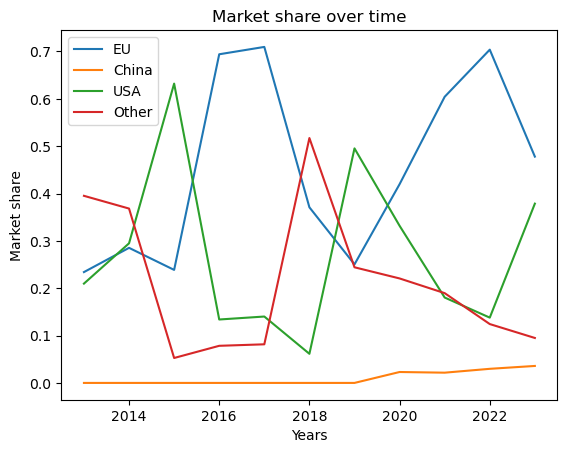

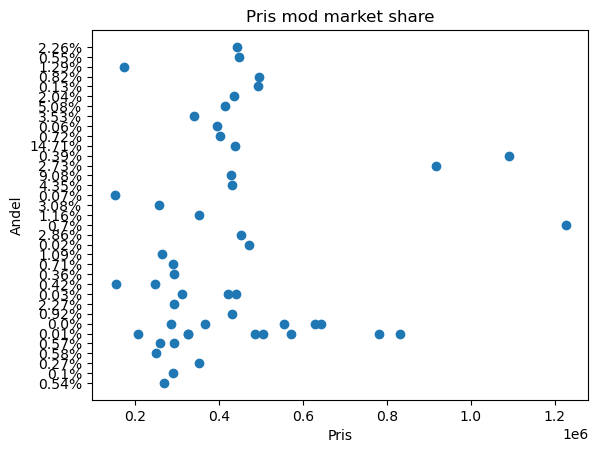

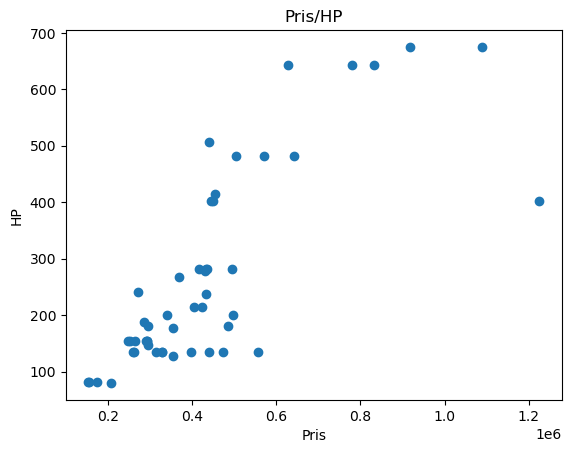

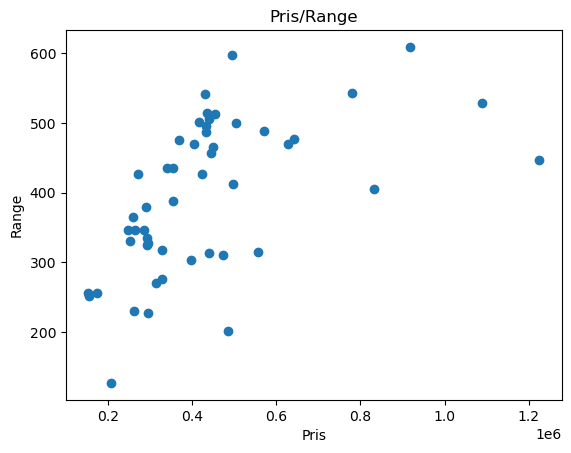

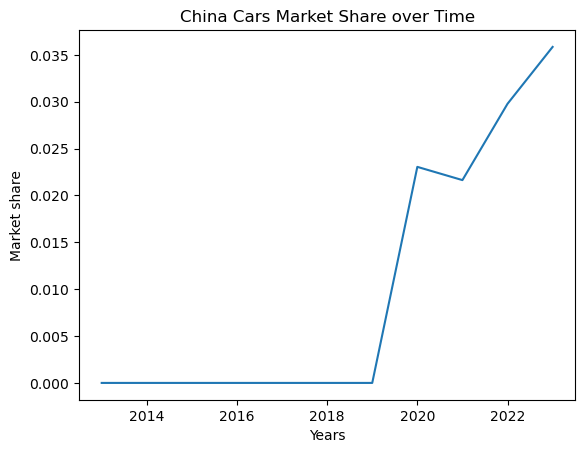

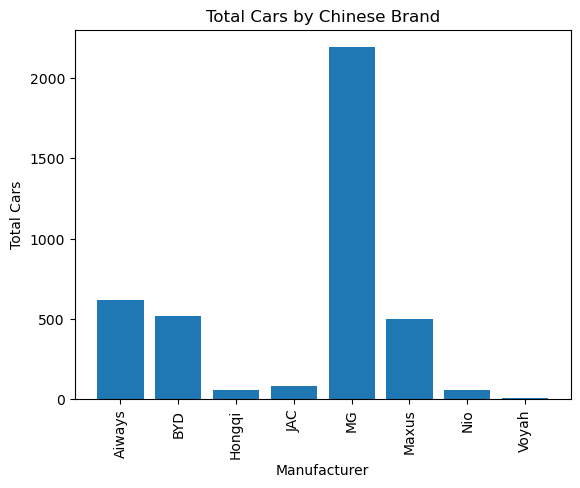

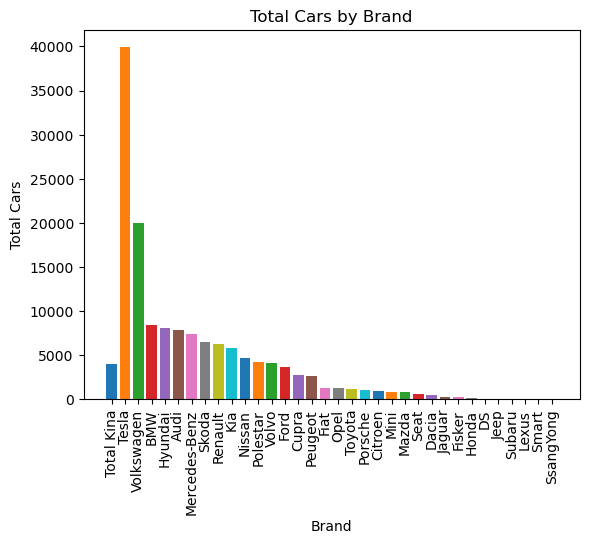

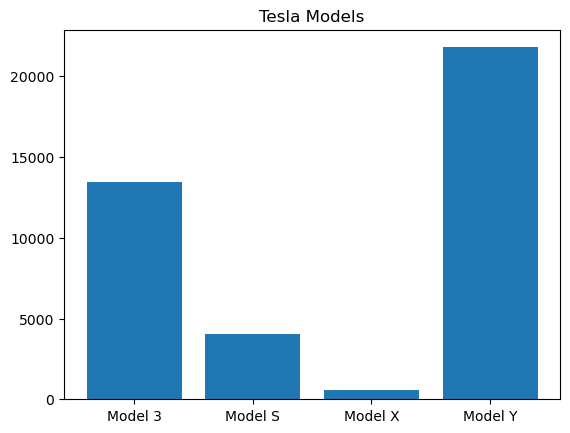

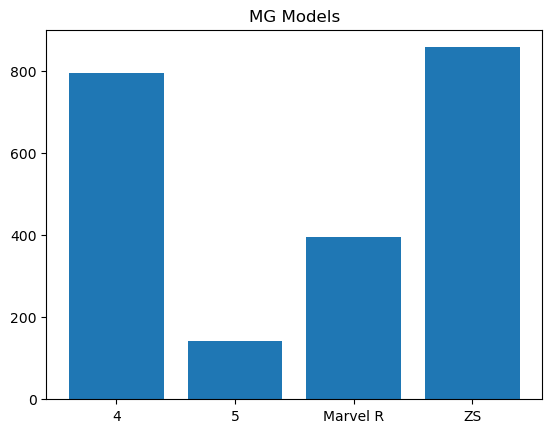

In [9]:
'''
Done
Hvem har størst market share? 
Pris mod market share
Pris/HP
Pris/Range
Hvordan ser det ud for kinesere isoleret?
Kinesere vs resten

Yet to come
Hvordan ser de største ud?
Størst udvikling i market share?
'''

#Market share over time
#plt.figure(figsize=(12, 6))
for region in region_shares.keys():
    plt.plot(years, region_shares[region])
plt.legend(['EU', 'China', 'USA', 'Other'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('Market share over time')
plt.show()

#Pris mod market share
# x = pris, y = andel
#plt.scatter(x,y)
#Kun for de 5 med højest andel
mængde = 50
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Andel[len(df_overview)-mængde:])
plt.title('Pris mod market share')
plt.xlabel('Pris')
plt.ylabel('Andel')
plt.show()

# Pris/HP
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.HP[len(df_overview)-mængde:])
plt.title('Pris/HP')
plt.xlabel('Pris')
plt.ylabel('HP')
plt.show()

#Pris/Range
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Range[len(df_overview)-mængde:])
plt.title('Pris/Range')
plt.xlabel('Pris')
plt.ylabel('Range')
plt.show()

#Market share over time
plt.plot(years, region_shares['China'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('China Cars Market Share over Time')
plt.show()

#Total Cars by Chinese Brand
df_china = df_overview[df_overview['China'] == 1]
brand_totals = df_china.groupby('Manufacturer')['Antal'].sum()

plt.bar(brand_totals.index, brand_totals.values)
plt.title('Total Cars by Chinese Brand')
plt.xlabel('Manufacturer')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Kinesere by brands
df_china = df_overview[df_overview['China'] == 1]

total_kina = df_china['Antal'].sum() #Alle kinesere (samlet)
plt.bar('Total Kina', total_kina)
plt.title('Total Cars by Chinese Brands')


#Alle ikke CH-brands mod total CH. 
df_not_china = df_overview[df_overview['China'] == 0]
not_china_totals = df_not_china.groupby('Manufacturer')['Antal'].sum() #Alle ikke kinesere(unikke)
sorted_not_china_totals = not_china_totals.sort_values(ascending=False)

for i, (brand, total) in enumerate(sorted_not_china_totals.items()):
    plt.bar(brand, total, label=brand)

plt.title('Total Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Tesla models (Største i EU)
df_tesla = df_overview[df_overview['Manufacturer'] == 'Tesla']
df_tesla = df_tesla.groupby('Model')['Antal'].sum()
plt.bar(df_tesla.index, df_tesla.values)
plt.title('Tesla Models')
plt.show()

#MG (største kinesiske mærke i DK)
df_mg = df_overview[df_overview['Manufacturer'] == 'MG']
df_mg = df_mg.groupby('Model')['Antal'].sum()
plt.bar(df_mg.index, df_mg.values)
plt.title('MG Models')
plt.show()



# Estimering

In [42]:
label_y = 'Market share'
label_x = ['Range', 'Price', 'HP', 'ChargeTime', 'China']
data_scaled = df_dataset
data_scaled['Range'] = data_scaled['Range'] / 100
data_scaled['Price'] = data_scaled['Price'] / 100000
data_scaled['HP'] = data_scaled['HP'] / 100
data_scaled['ChargeTime'] = data_scaled['ChargeTime'] / 100

## Standard OLS

In [41]:
#Bruger data hvor ms = 0 er inkluderet
data = df_dataset
N = data['ID'].unique().size
N
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

Data has N=112 and T=11 data is = 1232, 1232


In [28]:
#Bruger data hvor ms = 0 er inkludere
N
y = df_dataset['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = df_dataset['Range'].values.reshape((N*T,1)) #1
Price = df_dataset['Price'].values.reshape((N*T,1)) #2
HP = df_dataset['HP'].values.reshape((N*T,1)) #3
ChargeTime = df_dataset['ChargeTime'].values.reshape((N*T,1))  #4
China = df_dataset['China'].values.reshape((N*T,1)) #5

X = np.hstack([ones, Range, Price, HP, ChargeTime, China])
#print(f' y \n {y[:2]} \n ones: \n {ones[:2]} \n X: {X[:2]} \n {X.size} \n')

In [36]:
#OLS estimation
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')
print(results.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     10.21
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           1.35e-09
Time:                        13:47:28   Log-Likelihood:                 2164.3
No. Observations:                1232   AIC:                            -4317.
Df Residuals:                    1226   BIC:                            -4286.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0091      0.006     -1.475      0.1

In [37]:
#Bruger data hvor ms = 0 er ekskluderet
data = df_dataset_year_ms0[2023]

N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

Data has N=104 and T=1 data is = 104, 104


In [38]:
y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])


#OLS estimation
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')
print(results.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     3.129
Date:                Wed, 14 Feb 2024   Prob (F-statistic):             0.0116
Time:                        13:47:37   Log-Likelihood:                 227.21
No. Observations:                 104   AIC:                            -442.4
Df Residuals:                      98   BIC:                            -426.6
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.009      0.118      0.9

## Logit

In [43]:
#Estimere full sample med logit
data = data_scaled

N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

NameError: name 'data_scaled' is not defined

In [44]:
# Sample data generation

y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])


# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit(cov_type = 'HC3')

# Display results
print(result.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


Optimization terminated successfully.
         Current function value: 0.013244
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:           Market share   No. Observations:                 1232
Model:                          Logit   Df Residuals:                     1226
Method:                           MLE   Df Model:                            5
Date:                Wed, 14 Feb 2024   Pseudo R-squ.:                  -2.152
Time:                        13:51:42   Log-Likelihood:                -16.317
converged:                       True   LL-Null:                       -5.1762
Covariance Type:                  HC3   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0397      0.579    -10.428      0.000      -7.175      -4.905
Range          0.2901      0

## Conditional Logit

In [18]:

data = df_dataset
T = data['year'].unique().size
M = data['Model'].unique().size
#print(f'df {data.head(1)}, {data.shape}')

data = np.array(data[['Market share', 'Range', 'Price', 'HP', 'ChargeTime', 'China']])
#print(f'\n \n data: {data[:2]} \n shape {data.shape[1]}')
V = data.shape[1] - 1

y = data[:,0].reshape(M,1, T) #reshape for column vector
#print(f' \n \n y: {y[:2]} \n shape {y.shape}')

x = data[:,1:].reshape(M, V, T)
#print(f' \n \n x: {x[:2]} \n shape {x.shape}')

print(f' \n \n y shape {y.shape} \n \n x shape {x.shape}')

 
 
 y shape (112, 1, 11) 
 
 x shape (112, 5, 11)


In [19]:
def clogit(y, x, cov_type='Ainv', theta0=None, deriv=0, quiet=False): 
	# Objective function and derivatives for 
    M, V, T, palt, xalt, xvars = labels(x)

    Qfun     = lambda theta, out:  Q_clogit(theta, y, x, out)

    if theta0 is None: 
        theta0=np.zeros((T,1))

    res = estimation(Qfun, theta0, deriv, cov_type, parnames=xvars)
    #res.update(dict(zip(['yvar', 'xvars', 'Model','Tid', 'n'], ['y', xvars, M, V, M])))

    #if quiet==False:
    #    print('Conditional logit')
    #    print('Initial log-likelihood', -Qfun(theta0, 'Q'))
    #    print('Initial gradient\n', -Qfun(theta0, 'dQ'))
    #    print_output(res)

    #return res  




In [20]:
def labels(x):
    # labels and dimensions for plotting
    M, V, T = x.shape
    palt=['p' + str(i)  for i in range(V)]
    xalt=['alt' + str(i)  for i in range(V)]
    xvars=['var' + str(i)  for i in range(T)]
    return M, V, T, palt, xalt, xvars

In [21]:
def Q_clogit(theta, y, x, out='Q'):
    #N, J, K = x.shape
    M, V, T = x.shape
    
    #def utiliy(theta, x):
    #   u = x @ theta
	#   return u.reshape(N,V) 
    
    v = utiliy(theta, x) # v = x @ theta 	# Deterministic component of utility
    ll_i=logccp(v, y) 
    q_i= - ll_i   
    if out=='Q':
    	return np.mean(q_i)
    
    #Hvad bruger man de andre ting til?

    #dv=x
    #p=ccp(v)
    #if out=='predict':  return v, p, dv         # Return predicted values
    #N, J, K = dv.shape
    #idx=y[:,] + J*np.arange(0, N)
    #dvj=dv.reshape(N*J, K)[idx,:] 	# pick choice specific values corresponding to y 

    #s_i = dvj -  np.sum(p.reshape(N,J,1)*dv, axis=1)
    #g = -np.mean(s_i, axis=0)
    
    #if out=='s_i': return s_i                     # Return s_i: NxK array with scores
    #if out=='dQ':  return g;  # Return dQ: array of size K derivative of sample objective function


In [22]:
def logccp(v, y=None, sigma=1):
    # Log of conditional choice probabilities 
    # If y = None return logccp corresponding to all choices
    # if y is Nx1 vector of choice indexes, return likelihood
    ev = logsum(v, sigma) 	# Expected utility (always larger than V) For hvert alternativ?
    if y is not None:	
    	N, J=v.shape
    	idx=y[:,] + J*np.arange(0, N)
    	v=v.reshape(N*J, 1)[idx] 	# pick choice specific values corresponding to y 
    return (v - ev)/sigma

In [23]:
def logsum(v, sigma=1): # Maximal expected utility - the "log-sum"
	# Expected max over iid extreme value shocks with scale parameter sigma
	# Logsum is reentered around maximum to obtain numerical stability (avoids overflow, but accepts underflow)
	max_v = v.max(axis=1).reshape(-1, 1) #max_v = største værdi i hver række og derfor valget (y) uden støj.
	return max_v + sigma*np.log(np.sum(np.exp((v-max_v)/sigma), 1)).reshape(-1, 1)

In [24]:
def estimation(Qfun, theta0, deriv=0, cov_type ='sandwich', parnames='', output=False): 

    tic = time.perf_counter()
    
    # Q: Sample objective function to minimize (e.g. sample average of negative log-livelihood)
    Q = lambda theta:  Qfun(theta, out='Q')

    # dQ: Derivative of sample objective function wrt parameters theta (function returns size K array)
    dQ = None
    if deriv>0: # use user-supplied 1 order derivatives
        dQ = lambda theta:  Qfun(theta, out='dQ')

    hess = None
    if deriv>1: # use user-supplied 2 order derivatives
        hess  =  lambda theta:  Qfun(theta, out='H')
        result=minimize(fun=Q, jac=dQ, hess=hess, x0=theta0, method='trust-ncg')
        result.hess_inv=la.inv(result.hess)
    else: # use bfgs
        result=minimize(fun=Q, jac=dQ, x0=theta0, method='bfgs')
    
    theta_hat=np.array(result.x).reshape(-1,1)
    
    toc = time.perf_counter()

    # variance co-variance matrix
    s_i=Qfun(theta_hat, out='s_i')

    cov = avar(s_i, result.hess_inv, cov_type)
    se = np.sqrt(np.diag(cov)).reshape(-1, 1)

    # collect output
    names =   ['parnames', 'theta_hat', 'se',  't-values',  'cov', 'Q', 'time', 's_i']
    results = [parnames, theta_hat, se, theta_hat/se, cov, Q(theta_hat), toc - tic, s_i]

    result.update(dict(zip(names, results)))

    if output: 
        if result.parnames: 
            table=({k:result[k] for k in ['parnames', 'theta_hat', 'se', 't-values', 'jac']})
        else: 
            table=({k:result[k] for k in ['theta_hat', 'se', 't-values', 'jac']})
        print(tabulate(table, headers="keys",floatfmt="10.5f"))
        print('')
        print(result.message)
        print('Objective function:', result['Q'])
        print ('Iteration info: %d iterations, %d evaluations of objective, and %d evaluations of gradients' 
            % (result.nit,result.nfev, result.njev))
        print(f"Elapsed time: {result['time']:0.4f} seconds")

    return result

In [25]:
clogit(y, x, cov_type='Ainv',theta0=None, deriv=0, quiet=False)

C:\Users\Mikkel\AppData\Local\Temp\ipykernel_19440\3920226106.py:19: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result=minimize(fun=Q, jac=dQ, x0=theta0, method='bfgs')


ValueError: operands could not be broadcast together with shapes (112,1,11) (112,) 